# IoT GNN Demo

## Env Setup
Refer to the README.

## Imports

In [1]:
from configuration import *

from models import e_graphsage, fnn_model, enhanced_e_graphsage
from data import IoTDataset
import train
from train import ModelTrainer
import tester

/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
/home/rowleyra/anaconda3/envs/iot_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# NF-BoT-IoT

## Randomized IP Addresses and Ports

### Load Data
This assumes there is a "data" folder under the root of the IoT_GNN repo.  
Datasets can be found at: https://drive.google.com/drive/folders/14t41P09gXTsCqPx3YFN1Pruwb2eZQrkT?usp=share_link

In [2]:
multiclass = True
randomized_ip_train_data = IoTDataset(version=1, multiclass=multiclass)
randomized_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val')
randomized_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test')

### Model Initialization

In [3]:
# Multiclass
model_egs = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                              )
model_fnn = fnn_model.TestFNN(num_hidden_layers=2,
                               hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                               num_edge_attr=randomized_ip_train_data.num_features,
                               num_classes=len(randomized_ip_train_data.classes),
                              )
model_egsh = enhanced_e_graphsage.Enhanced_E_GraphSAGE(numLayers=2,
                                                       dim_node_embed=128,
                                                       num_edge_attr=randomized_ip_train_data.num_features,
                                                       num_classes=len(randomized_ip_train_data.classes),
                                                       attention=False, gating=False, residual=False
                                                      )

In [4]:
# Multiclass
egs_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 100,
}
fnn_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 100,
}
egsh_training_config = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 100,
}

### Training

In [5]:
# For development purposes, if the train module was modified, it can be reloaded.
import importlib
importlib.reload(train)

<module 'train' from '/home/rowleyra/IoT_GNN/train.py'>

In [6]:
# Instantiate Trainer
# Multiclass
egs_trainer = ModelTrainer(egs_training_config, randomized_ip_train_data, randomized_ip_val_data)
fnn_trainer = ModelTrainer(fnn_training_config, randomized_ip_train_data, randomized_ip_val_data)
egsh_trainer = ModelTrainer(egsh_training_config, randomized_ip_train_data, randomized_ip_val_data)

In [7]:
# Train the GNN
_ = egs_trainer.train_model(model_egs, False)

Training E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:32<00:00,  9.12epoch/s, train loss=0.6234, validation loss=0.6785, learning rate=1.00e-03, F1 score=0.74702]


In [8]:
# Train the FCNN
_ = fnn_trainer.train_model(model_fnn, False)

Training FCNN_K2: 100%|██████████| 300/300 [00:25<00:00, 11.63epoch/s, train loss=1.0010, validation loss=0.7004, learning rate=1.00e-03, F1 score=0.78033]


In [9]:
# Train the EGSH
_ = egsh_trainer.train_model(model_egsh, False)

Training Enhanced_E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:57<00:00,  5.24epoch/s, train loss=0.5921, validation loss=0.6994, learning rate=1.00e-03, F1 score=0.74950]


### Testing

In [10]:
# For development purposes, if the tester module was modified, it can be reloaded.
import importlib
importlib.reload(tester)

<module 'tester' from '/home/rowleyra/IoT_GNN/tester.py'>

In [11]:
tester_inst = tester.ModelTester(randomized_ip_test_data, True)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.176316
Recall:    0.921717
F1-score:  0.296009

== DDoS ==
Precision: 0.389943
Recall:    0.976161
F1-score:  0.557274

== DoS ==
Precision: 0.000000
Recall:    0.000000
F1-score:  0.000000

== Reconnaissance ==
Precision: 0.995329
Recall:    0.780997
F1-score:  0.875232

== Theft ==
Precision: 0.053740
Recall:    0.447644
F1-score:  0.095960

== weighted avg ==
Precision: 0.821809
Recall:    0.727704
F1-score:  0.746365

= Global Metrics =
Accuracy:           0.727704
Balanced Accuracy:  0.625304

Confusion Matrix:
[[ 2555    55     1    94    67]
 [   22 11097     0    19   230]
 [   28 11079     0    21   239]
 [11886  6227    27 73516  2475]
 [    0     0     0   211   171]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2555
TP: 105312
FN: 11936
FP: 217

Accuracy: 0.898742
Balanced Acc

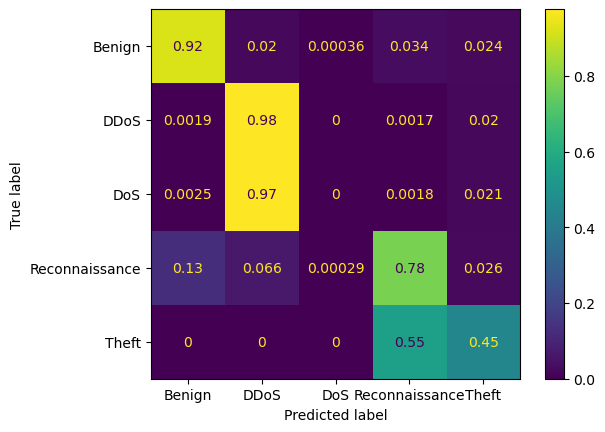

In [12]:
tester_inst.test_model(model_egs)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.209886
Recall:    0.965007
F1-score:  0.344783

== DDoS ==
Precision: 0.463074
Recall:    0.128519
F1-score:  0.201198

== DoS ==
Precision: 0.375400
Recall:    0.836896
F1-score:  0.518307

== Reconnaissance ==
Precision: 0.994098
Recall:    0.817669
F1-score:  0.897293

== Theft ==
Precision: 0.123338
Recall:    0.437173
F1-score:  0.192396

== weighted avg ==
Precision: 0.864320
Recall:    0.756407
F1-score:  0.780463

= Global Metrics =
Accuracy:           0.756407
Balanced Accuracy:  0.637053

Confusion Matrix:
[[ 2675    15    49    16    17]
 [    7  1461  9554   116   230]
 [    7  1492  9513   116   239]
 [10050   187  6225 76968   701]
 [    6     0     0   209   167]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2675
TP: 107178
FN: 10070
FP: 97

Accuracy: 0.915289
Balanced Accu

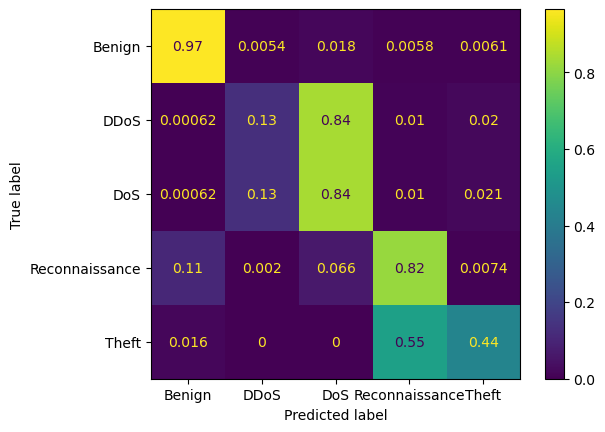

In [13]:
tester_inst.test_model(model_fnn)

Total Samples: 120020
===== Multiclass Test Report =====
== Benign ==
Precision: 0.179388
Recall:    0.919913
F1-score:  0.300230

== DDoS ==
Precision: 0.000000
Recall:    0.000000
F1-score:  0.000000

== DoS ==
Precision: 0.388996
Recall:    0.974663
F1-score:  0.556063

== Reconnaissance ==
Precision: 0.995284
Recall:    0.784726
F1-score:  0.877551

== Theft ==
Precision: 0.055126
Recall:    0.447644
F1-score:  0.098163

== weighted avg ==
Precision: 0.821756
Recall:    0.730437
F1-score:  0.748169

= Global Metrics =
Accuracy:           0.730437
Balanced Accuracy:  0.625389

Confusion Matrix:
[[ 2550     1    55    99    67]
 [   22     0 11097    19   230]
 [   28     0 11079    21   239]
 [11615     4  6250 73867  2395]
 [    0     0     0   211   171]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 120020
TN: 2550
TP: 105583
FN: 11665
FP: 222

Accuracy: 0.900958
Balanced Acc

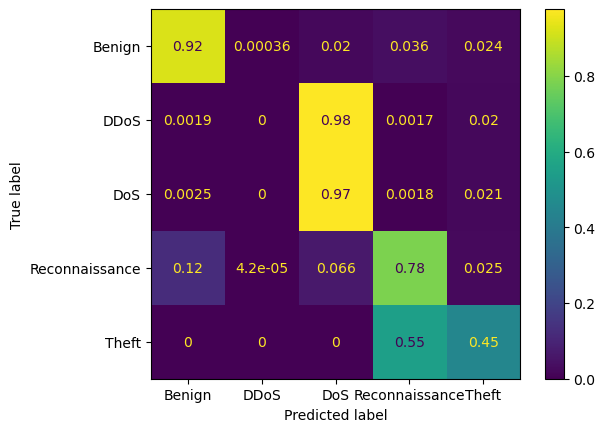

In [14]:
tester_inst.test_model(model_egsh)

## Non-Randomized IP Addresses and Ports

### Load Data

In [15]:
multiclass = True
orig_ip_train_data = IoTDataset(version=1, multiclass=multiclass, randomize_source_ip=False)
orig_ip_val_data = IoTDataset(version=1, multiclass=multiclass, split='val', randomize_source_ip=False)
orig_ip_test_data = IoTDataset(version=1, multiclass=multiclass, split='test', randomize_source_ip=False)

### Model Initialization

In [16]:
# Multiclass
model_egs_orig = e_graphsage.E_GraphSAGE(numLayers=2,
                                dim_node_embed=128,
                                num_edge_attr=randomized_ip_train_data.num_features,
                                num_classes=len(randomized_ip_train_data.classes)
                              )
model_fnn_orig = fnn_model.TestFNN(num_hidden_layers=2,
                               hidden_layer_widths=[128, 192],  # Should be approximately comparable to EGS
                               num_edge_attr=randomized_ip_train_data.num_features,
                               num_classes=len(randomized_ip_train_data.classes),
                              )
model_egsh_orig = enhanced_e_graphsage.Enhanced_E_GraphSAGE(numLayers=2,
                                                       dim_node_embed=128,
                                                       num_edge_attr=randomized_ip_train_data.num_features,
                                                       num_classes=len(randomized_ip_train_data.classes),
                                                       attention=False, gating=False, residual=False
                                                      )

### Training

In [17]:
# Multiclass
egs_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 100,
}
fnn_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 100,
}
egsh_training_config_orig = {
        'num_epochs': 300,
        'lr': 1e-3,
        'gpu': True,
        'lr_sched_factor': np.sqrt(10),
        'lr_sched_patience': 100,
}

In [18]:
# Instantiate Trainer
# Multiclass
egs_orig_trainer = ModelTrainer(egs_training_config_orig, orig_ip_train_data, orig_ip_val_data)
fnn_orig_trainer = ModelTrainer(fnn_training_config_orig, orig_ip_train_data, orig_ip_val_data)
egsh_orig_trainer = ModelTrainer(egsh_training_config_orig, orig_ip_train_data, orig_ip_val_data)

In [19]:
# Train the GNN
_ = egs_orig_trainer.train_model(model_egs_orig, False)

Training E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:22<00:00, 13.17epoch/s, train loss=0.5131, validation loss=0.6144, learning rate=1.00e-03, F1 score=0.46398]


In [20]:
# Train the FCNN
_ = fnn_orig_trainer.train_model(model_fnn_orig, False)

Training FCNN_K2: 100%|██████████| 300/300 [00:22<00:00, 13.13epoch/s, train loss=0.9463, validation loss=0.7087, learning rate=1.00e-03, F1 score=0.78569]


In [21]:
# Train the EGSH
_ = egsh_orig_trainer.train_model(model_egsh_orig, False)

Training Enhanced_E_GraphSAGE_K2_H128: 100%|██████████| 300/300 [00:24<00:00, 12.37epoch/s, train loss=0.3995, validation loss=0.5900, learning rate=1.00e-03, F1 score=0.60097]


### Testing

In [22]:
tester_inst_orig = tester.ModelTester(orig_ip_test_data, True)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.173687
Recall:    0.969659
F1-score:  0.294603

== DDoS ==
Precision: 0.129032
Recall:    0.000467
F1-score:  0.000930

== DoS ==
Precision: 0.395053
Recall:    0.994993
F1-score:  0.565557

== Reconnaissance ==
Precision: 0.998046
Recall:    0.448530
F1-score:  0.618915

== Theft ==
Precision: 0.008592
Recall:    0.974603
F1-score:  0.017034

== weighted avg ==
Precision: 0.865157
Recall:    0.468639
F1-score:  0.559008

= Global Metrics =
Accuracy:           0.468639
Balanced Accuracy:  0.677650

Confusion Matrix:
[[ 2301     3     1    49    19]
 [    8     4  8529    15    17]
 [    3    12  8545    12    16]
 [10936     9  4555 41376 35372]
 [    0     3     0     5   307]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2301
TP: 98777
FN: 10947
FP: 72

Accuracy: 0.901701
Balanced Accur

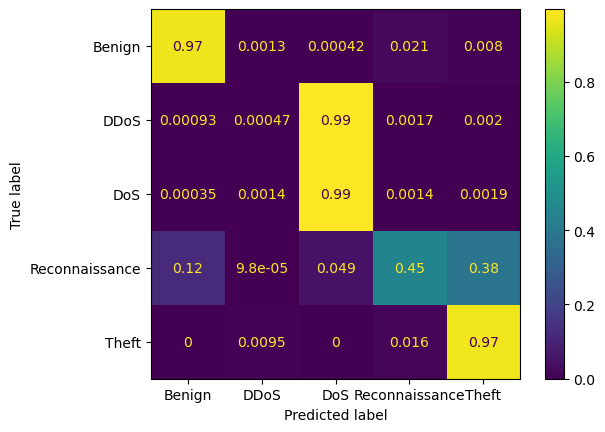

In [23]:
tester_inst_orig.test_model(model_egs_orig)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.187900
Recall:    0.964602
F1-score:  0.314531

== DDoS ==
Precision: 0.333333
Recall:    0.009332
F1-score:  0.018155

== DoS ==
Precision: 0.391199
Recall:    0.977177
F1-score:  0.558722

== Reconnaissance ==
Precision: 0.994454
Recall:    0.837774
F1-score:  0.909415

== Theft ==
Precision: 0.172888
Recall:    0.279365
F1-score:  0.213592

== weighted avg ==
Precision: 0.878293
Recall:    0.786212
F1-score:  0.799837

= Global Metrics =
Accuracy:           0.786212
Balanced Accuracy:  0.613650

Confusion Matrix:
[[ 2289     3    56    15    10]
 [   10    80  8378   103     2]
 [   16    84  8392    94     2]
 [ 9861    71  4626 77283   407]
 [    6     2     0   219    88]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2289
TP: 99831
FN: 9893
FP: 84

Accuracy: 0.910997
Balanced Accura

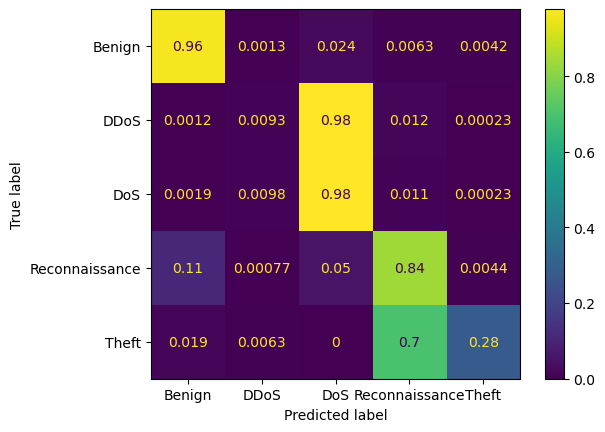

In [24]:
tester_inst_orig.test_model(model_fnn_orig)

Total Samples: 112097
===== Multiclass Test Report =====
== Benign ==
Precision: 0.176533
Recall:    0.973873
F1-score:  0.298888

== DDoS ==
Precision: 0.202899
Recall:    0.001633
F1-score:  0.003240

== DoS ==
Precision: 0.394923
Recall:    0.992781
F1-score:  0.565066

== Reconnaissance ==
Precision: 0.998810
Recall:    0.600360
F1-score:  0.749946

== Theft ==
Precision: 0.014110
Recall:    0.980952
F1-score:  0.027819

== weighted avg ==
Precision: 0.871501
Recall:    0.593611
F1-score:  0.667097

= Global Metrics =
Accuracy:           0.593611
Balanced Accuracy:  0.709920

Confusion Matrix:
[[ 2311     3     1    38    20]
 [    8    14  8519    15    17]
 [    5    31  8526    11    15]
 [10766    18  4543 55382 21539]
 [    1     3     0     2   309]]

= Binary Metrics =
TN, TP, FN, FP are derived from the confusion matrix.
Benign is the negative class. The attack classes are positive.
Total Samples: 112097
TN: 2311
TP: 98944
FN: 10780
FP: 62

Accuracy: 0.903280
Balanced Accur

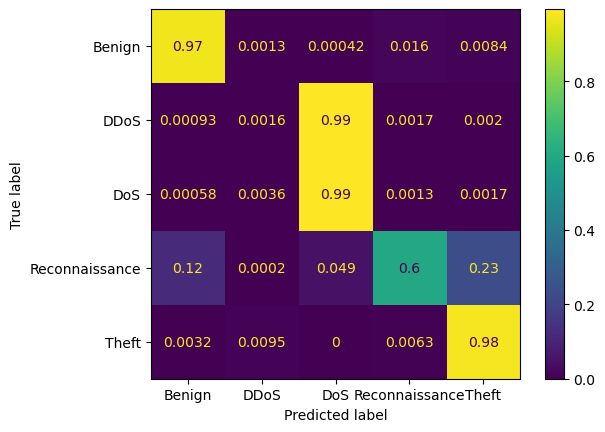

In [25]:
tester_inst_orig.test_model(model_egsh_orig)